In [7]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override() # This is crucial to avioid list constraints

""" Used to analyse complex financial instruments by varying the uncertainities and take an average over a large range of outcomes, it is a brute force approach. 
It is used in a risk neutral world. (The buyer is indifferent to risk)
Uncertainity is indirectly proportional to sqrt(iteration)
Assumption:
Absence or existance of jumps, distribution"""


' Used to analyse complex financial instruments by varying the uncertainities and take an average over a large range of outcomes, it is a brute force approach. \nIt is used in a risk neutral world. (The buyer is indifferent to risk)\nUncertainity is indirectly proportional to sqrt(iteration)\nAssumption:\nAbsence or existance of jumps, distribution'

In [8]:
# Python datareader is a package that allows us to reate dataframes from sources on the internet, most used for finance. How to use it?
# yfin is not an official part of yahoo finance but instead is a open soruce library that makes use of Yahoo's public data. 
# start_date = "2020-01-1"
# end_date = "2020-12-31"
# df1 = pdr.DataReader("META", start = start_date, end= end_date)
# print(df1)

# or we can make use of get_data_yahoo directly.
# df2 = pdr.get_data_yahoo("META", start = start_date, end = end_date)
# print(df2)


# df1 = pdr.get_data_yahoo("META", start = "2022-01-01", end = "2023-01-01")
# return1 = df1.pct_change()
# print(return1)

In [9]:
# This function is designed to import the data from the internet and conpute the meanReturns and CovMatrix
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    # Here pct.change() stands for percentage change form teh immediate previous element in the dataframe (new - old / old)
    # s = pd.Series([90, 91, 85])
    # s.pct_change(); NaN, 0.01111, -0.06593
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [10]:
# This stock list comprises of major ompanies trading at NSE. 
stockList = ['HDFCBANK', 'LT', 'BPCL', 'M&M', 'JIOFIN', 'TCS']
stocks = [stock + '.NS' for stock in stockList]
endDate = datetime.datetime.now()
# A start date of one year prior to the present is chosen. 
startDate = endDate - datetime.timedelta(days=365)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%%**********************]  6 of 6 completed


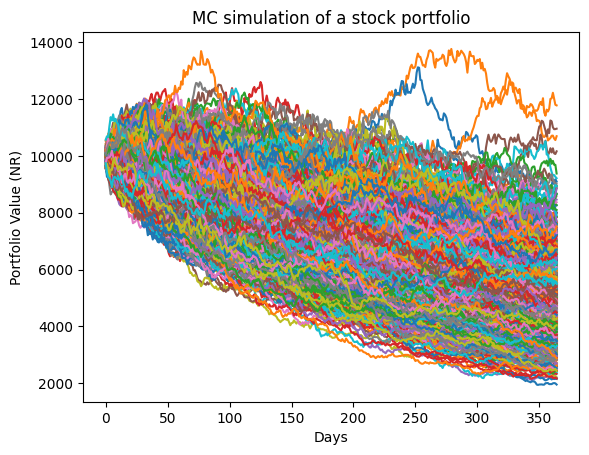

VaR_5 INR 7110.12
CVaR_5 INR 7433.82


In [11]:
# Monte Carlo Simulation 
no_mcs = 1000 # number of simulations
T = 365 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
# print(meanM.shape)
meanM = meanM.T # dot product for the arrays
portfolio_sims = np.full(shape=(T, no_mcs), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, no_mcs):
    Z = np.random.normal(size=(T, len(weights))) # uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #C holesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) # Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio # Price today = Price yeasterday * (1 + growth rate)
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value (NR)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
        
portResults = pd.Series(portfolio_sims[-1,:])
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)
print('VaR_5 INR {}'.format(round(VaR,2)))
print('CVaR_5 INR {}'.format(round(CVaR,2)))